# Step 1: Setup Environment and Download Sample Data

Attempting download from COCO dataset...
Success: /content/scene_understanding_pipeline/input_images/image_001.jpg
Success: /content/scene_understanding_pipeline/input_images/image_002.jpg
Success: /content/scene_understanding_pipeline/input_images/image_003.jpg

Total images ready: 3


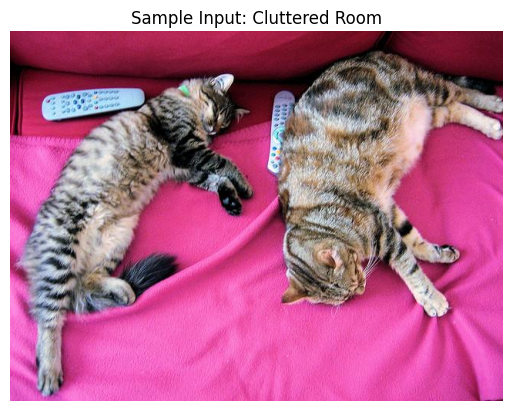

In [1]:
import os
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 1. Re-confirm Directory Structure
base_path = '/content/scene_understanding_pipeline'
os.makedirs(f'{base_path}/input_images', exist_ok=True)
os.makedirs(f'{base_path}/phase1_detections', exist_ok=True)
os.makedirs(f'{base_path}/phase2_patches', exist_ok=True)
os.makedirs(f'{base_path}/phase3_captions', exist_ok=True)
os.makedirs(f'{base_path}/phase4_reasoning', exist_ok=True)

# 2. Use COCO Dataset URLs (More reliable than Flickr)
# These images match your paper's need for "complex" scenes (living rooms, kitchens)
coco_urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg", # Room with cats and remote (cluttered)
    "http://images.cocodataset.org/val2017/000000000139.jpg", # Living room with TV and furniture
    "http://images.cocodataset.org/val2017/000000289343.jpg"  # Kitchen with many small objects
]

def download_image(url, save_path):
    try:
        # User-agent header often helps bypass basic blockers
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img.save(save_path)
        print(f"Success: {save_path}")
        return True
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False

print("Attempting download from COCO dataset...")
count = 0
for i, url in enumerate(coco_urls):
    filename = f"image_{i+1:03d}.jpg"
    save_path = f"{base_path}/input_images/{filename}"
    if download_image(url, save_path):
        count += 1

# 3. Verification
print(f"\nTotal images ready: {count}")

if count > 0:
    # Show the first image to prove it works
    img = Image.open(f"{base_path}/input_images/image_001.jpg")
    plt.imshow(img)
    plt.axis('off')
    plt.title("Sample Input: Cluttered Room")
    plt.show()
else:
    print("!!! Automatic download failed again.")
    print("Please manually drag and drop 3 .jpg files into the folder:")
    print("/content/scene_understanding_pipeline/input_images/")

In [2]:
import os
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# 1. Re-confirm Directory Structure
base_path = '/content/scene_understanding_pipeline'
os.makedirs(f'{base_path}/input_images', exist_ok=True)
os.makedirs(f'{base_path}/phase1_detections', exist_ok=True)
os.makedirs(f'{base_path}/phase2_patches', exist_ok=True)
os.makedirs(f'{base_path}/phase3_captions', exist_ok=True)
os.makedirs(f'{base_path}/phase4_reasoning', exist_ok=True)

# --- CONFIGURATION ---
NUM_IMAGES = 60  # The target for a strong statistical paper
# ---------------------

input_dir = f'{base_path}/input_images'
os.makedirs(input_dir, exist_ok=True)

# Helper to check if image is valid/complex enough (file size > 100KB usually implies details)
def download_coco_image(image_id):
    base_url = "http://images.cocodataset.org/val2017/"
    # Format ID to 12 digits
    formatted_id = str(image_id).zfill(12)
    url = f"{base_url}{formatted_id}.jpg"

    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        resp = requests.get(url, headers=headers, timeout=2)

        if resp.status_code == 200:
            # Check size to avoid empty/tiny images
            if len(resp.content) > 50000: # >50KB
                save_path = f"{input_dir}/image_{formatted_id}.jpg"
                Image.open(BytesIO(resp.content)).save(save_path)
                return True
    except:
        pass
    return False

print(f"Starting download of {NUM_IMAGES} images from COCO...")

count = 0
# We iterate through IDs starting from a random point to get a variety
# Using a range in the validation set
current_id = 139

while count < NUM_IMAGES:
    if download_coco_image(current_id):
        count += 1
        print(f"[{count}/{NUM_IMAGES}] Downloaded image_{str(current_id).zfill(12)}.jpg")

    current_id += 1
    # Safety break to prevent infinite loops if internet fails
    if current_id > 10000:
        print("Scanned too many IDs without success. Stopping.")
        break

print(f"\nDownload Complete. {count} images are ready for processing.")
print("Directory: /content/scene_understanding_pipeline/input_images")

Starting download of 60 images from COCO...
[1/60] Downloaded image_000000000139.jpg
[2/60] Downloaded image_000000000285.jpg
[3/60] Downloaded image_000000000632.jpg
[4/60] Downloaded image_000000000724.jpg
[5/60] Downloaded image_000000000776.jpg
[6/60] Downloaded image_000000000785.jpg
[7/60] Downloaded image_000000000802.jpg
[8/60] Downloaded image_000000000872.jpg
[9/60] Downloaded image_000000000885.jpg
[10/60] Downloaded image_000000001000.jpg
[11/60] Downloaded image_000000001268.jpg
[12/60] Downloaded image_000000001296.jpg
[13/60] Downloaded image_000000001353.jpg
[14/60] Downloaded image_000000001425.jpg
[15/60] Downloaded image_000000001490.jpg
[16/60] Downloaded image_000000001532.jpg
[17/60] Downloaded image_000000001584.jpg
[18/60] Downloaded image_000000001675.jpg
[19/60] Downloaded image_000000001761.jpg
[20/60] Downloaded image_000000001818.jpg
[21/60] Downloaded image_000000001993.jpg
[22/60] Downloaded image_000000002006.jpg
[23/60] Downloaded image_000000002149.jpg

# Phase 1: Object Detection Agent (DETR)

In [3]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import json

# --- CONFIGURATION ---
CONFIDENCE_THRESHOLD = 0.7  # Only keep confident detections
# ---------------------

# 1. Load Model (Facebook's DETR-ResNet-50)
print("Loading Object Detector (DETR)...")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Model loaded on {device}")

# 2. Processing Function
def detect_objects(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocess
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process (convert outputs to COCO bounding box format)
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=CONFIDENCE_THRESHOLD)[0]

    detected_objects = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()] # x1, y1, x2, y2
        label_name = model.config.id2label[label.item()]

        # Structure matching your Paper's "Output Structure" [cite: 27]
        obj_data = {
            "label": label_name,
            "confidence": round(score.item(), 3),
            "bbox": box
        }
        detected_objects.append(obj_data)

    return detected_objects

# 3. Execution Loop
input_dir = f'{base_path}/input_images'
output_dir = f'{base_path}/phase1_detections'
image_files = [f for f in os.listdir(input_dir) if f.endswith('.jpg')]

print(f"\nProcessing {len(image_files)} images...")

for img_file in image_files:
    print(f"Detecting objects in {img_file}...")
    full_path = os.path.join(input_dir, img_file)

    # Run Detection
    detections = detect_objects(full_path)

    # Assign IDs like "Obj1", "Obj2" as per paper [cite: 31]
    formatted_output = {"objects": []}
    for idx, obj in enumerate(detections):
        obj["id"] = f"Obj{idx+1}"
        formatted_output["objects"].append(obj)

    # Save to JSON
    json_filename = img_file.replace('.jpg', '.json')
    with open(os.path.join(output_dir, json_filename), 'w') as f:
        json.dump(formatted_output, f, indent=4)

print("\nPhase 1 Complete. Check the 'phase1_detections' folder.")
# Print one example to verify
if image_files:
    example_json = os.path.join(output_dir, image_files[0].replace('.jpg', '.json'))
    with open(example_json, 'r') as f:
        print(f"Sample Output ({example_json}):")
        print(json.dumps(json.load(f), indent=2))

Loading Object Detector (DETR)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Model loaded on cuda

Processing 63 images...
Detecting objects in image_000000006040.jpg...
Detecting objects in image_000000006460.jpg...
Detecting objects in image_000000002431.jpg...
Detecting objects in image_000000004795.jpg...
Detecting objects in image_000000002153.jpg...
Detecting objects in image_000000000724.jpg...
Detecting objects in image_000000002532.jpg...
Detecting objects in image_000000005992.jpg...
Detecting objects in image_000000004395.jpg...
Detecting objects in image_000000005529.jpg...
Detecting objects in image_000000005060.jpg...
Detecting objects in image_000000006213.jpg...
Detecting objects in image_000000002473.jpg...
Detecting objects in image_003.jpg...
Detecting objects in image_000000001268.jpg...
Detecting objects in image_000000002587.jpg...
Detecting objects in image_000000001993.jpg...
Detecting objects in image_000000003255.jpg...
Detecting objects in image_000000005503.jpg...
Detecting objects in image_000000003501.jpg...
Detecting objects in im

# Phase 2: Object Patch Extraction with Filtering & Upscaling

Reprocessing patches for 63 images...

--- Phase 2 Improved Statistics ---
Total Detections: 542
Discarded (Noise): 156
Saved (Clean):    386
Patches saved to: /content/scene_understanding_pipeline/phase2_patches

--- Visualizing 3 Resized Sample Patches ---


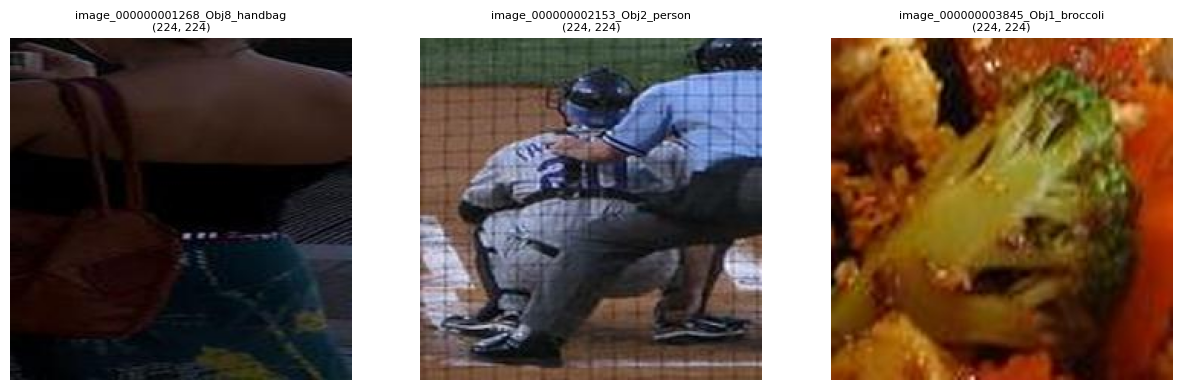

In [4]:
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

# --- RESEARCH CONFIGURATION ---
PADDING_PERCENT = 0.10   # Expand box to capture context
MIN_PIXEL_SIZE = 25      # Discard objects smaller than 25x25 (removes noise)
TARGET_SIZE = (224, 224) # Standard input size for VLMs (fixes pixelation)
# ------------------------------

def expand_box(box, image_size, padding_pct):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    w_pad = width * padding_pct
    h_pad = height * padding_pct

    new_xmin = max(0, xmin - w_pad)
    new_ymin = max(0, ymin - h_pad)
    new_xmax = min(image_size[0], xmax + w_pad)
    new_ymax = min(image_size[1], ymax + h_pad)

    return [new_xmin, new_ymin, new_xmax, new_ymax]

input_img_dir = f'{base_path}/input_images'
input_json_dir = f'{base_path}/phase1_detections'
output_patch_dir = f'{base_path}/phase2_patches'

# Clear previous patches to avoid confusion
for f in os.listdir(output_patch_dir):
    os.remove(os.path.join(output_patch_dir, f))

json_files = [f for f in os.listdir(input_json_dir) if f.endswith('.json')]
print(f"Reprocessing patches for {len(json_files)} images...")

stats = {
    "total_detected": 0,
    "kept": 0,
    "discarded_too_small": 0
}

for json_file in json_files:
    with open(os.path.join(input_json_dir, json_file), 'r') as f:
        data = json.load(f)

    img_filename = json_file.replace('.json', '.jpg')
    try:
        original_image = Image.open(os.path.join(input_img_dir, img_filename)).convert("RGB")
    except:
        continue

    # Filtered list to update the JSON later (Optional, but good for consistency)
    valid_objects = []

    for obj in data['objects']:
        stats["total_detected"] += 1
        bbox = obj['bbox']
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]

        # 1. FILTER: Check if object is too small
        if width < MIN_PIXEL_SIZE or height < MIN_PIXEL_SIZE:
            stats["discarded_too_small"] += 1
            continue # Skip this object

        # 2. CROP: Expand and crop
        expanded_box = expand_box(bbox, original_image.size, PADDING_PERCENT)
        patch = original_image.crop((expanded_box[0], expanded_box[1], expanded_box[2], expanded_box[3]))

        # 3. UPSCALE: Resize to target size (224x224) using high-quality resampling
        # This fixes the "pixelated" view for the VLM
        patch = patch.resize(TARGET_SIZE, resample=Image.BICUBIC)

        # Save
        patch_filename = f"{img_filename.replace('.jpg', '')}_{obj['id']}_{obj['label']}.jpg"
        patch.save(os.path.join(output_patch_dir, patch_filename))

        valid_objects.append(obj)
        stats["kept"] += 1

print("\n--- Phase 2 Improved Statistics ---")
print(f"Total Detections: {stats['total_detected']}")
print(f"Discarded (Noise): {stats['discarded_too_small']}")
print(f"Saved (Clean):    {stats['kept']}")
print(f"Patches saved to: {output_patch_dir}")

# --- Verification ---
print("\n--- Visualizing 3 Resized Sample Patches ---")
patch_files = os.listdir(output_patch_dir)[:3]
if patch_files:
    plt.figure(figsize=(15, 5))
    for i, p_file in enumerate(patch_files):
        p_path = os.path.join(output_patch_dir, p_file)
        img = Image.open(p_path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{p_file.split('.')[0]}\n{img.size}", fontsize=8)
    plt.show()

# Phase 3: Patch-Level Captioning Agent (BLIP-2)

In [5]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import os
import json
import gc

# 1. CLEANUP: Clear GPU Memory from previous phases
# This is critical in Colab to avoid "Out of Memory" errors
if 'model' in globals(): del model
if 'processor' in globals(): del processor
torch.cuda.empty_cache()
gc.collect()
print("GPU Memory Flushed.")

# 2. LOAD CAPTIONING MODEL (BLIP-2)
print("Loading BLIP-2 Model (this may take a minute)...")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# Load in 16-bit precision (fp16) to save memory and speed up inference
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
    device_map="auto"
)
print("BLIP-2 Loaded Successfully.")

# 3. CAPTIONING LOOP
patch_dir = f'{base_path}/phase2_patches'
output_dir = f'{base_path}/phase3_captions'
input_json_dir = f'{base_path}/phase1_detections'

# Helper to group patches by their parent image
# We want one JSON file per original image, containing all its object captions
patch_files = [f for f in os.listdir(patch_dir) if f.endswith('.jpg')]
parent_map = {} # { "image_003": ["patch_filename1", "patch_filename2"] }

for p in patch_files:
    # distinct filename structure: image_003_Obj1_bicycle.jpg
    # split by first underscore to find parent
    # A bit tricky because image name has underscores too.
    # Let's rely on the detector JSONs to drive the loop to be safe.
    pass

# Better Strategy: Iterate over original Detection JSONs to maintain structure
json_files = [f for f in os.listdir(input_json_dir) if f.endswith('.json')]

print(f"\nGenerating captions for {len(json_files)} scenes...")

for json_file in json_files:
    image_id = json_file.replace('.json', '') # e.g., image_003

    # Prepare output structure
    scene_captions = {
        "image_id": image_id,
        "object_captions": {}
    }

    # Load detection data to know which objects we expect
    with open(os.path.join(input_json_dir, json_file), 'r') as f:
        detection_data = json.load(f)

    print(f"Processing scene: {image_id}")

    for obj in detection_data['objects']:
        obj_id = obj['id']
        label = obj['label']

        # Construct expected patch filename
        # matching the naming convention from Phase 2
        patch_name = f"{image_id}_{obj_id}_{label}.jpg"
        patch_path = os.path.join(patch_dir, patch_name)

        if not os.path.exists(patch_path):
            # This object was filtered out in Phase 2 (too small)
            continue

        # Open Image
        image = Image.open(patch_path).convert('RGB')

        # PROMPT ENGINEERING for Phase 3
        # We want details about appearance and state [cite: 63]
        prompt = "Question: Describe this image in detail, focusing on appearance, color, and material. Answer:"

        inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda", torch.float16)

        generated_ids = model.generate(**inputs, max_new_tokens=50)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

        # Store result
        scene_captions["object_captions"][obj_id] = {
            "label_from_detector": label,
            "visual_description": generated_text
        }

    # Save Phase 3 Output
    output_filename = os.path.join(output_dir, f"{image_id}_captions.json")
    with open(output_filename, 'w') as f:
        json.dump(scene_captions, f, indent=4)

print(f"\nPhase 3 Complete. Captions saved to: {output_dir}")

# --- Verification ---
# Let's check the caption for that "TV/Fireplace" or a Bike
if json_files:
    example_out = os.path.join(output_dir, json_files[0].replace('.json', '_captions.json'))
    if os.path.exists(example_out):
        with open(example_out, 'r') as f:
            print(f"\nSample Output ({example_out}):")
            print(json.dumps(json.load(f), indent=2))

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


GPU Memory Flushed.
Loading BLIP-2 Model (this may take a minute)...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 Loaded Successfully.

Generating captions for 63 scenes...
Processing scene: image_000000004395
Processing scene: image_000000001425
Processing scene: image_000000006460
Processing scene: image_000000002473
Processing scene: image_000000000776
Processing scene: image_000000003156
Processing scene: image_000000001296
Processing scene: image_000000001000
Processing scene: image_000000001584
Processing scene: image_000000003501
Processing scene: image_000000004134
Processing scene: image_000000000885
Processing scene: image_000000004795
Processing scene: image_000000005600
Processing scene: image_000000006040
Processing scene: image_000000001490
Processing scene: image_000000005060
Processing scene: image_000000000785
Processing scene: image_000000005193
Processing scene: image_000000004765
Processing scene: image_000000002299
Processing scene: image_000000002685
Processing scene: image_000000002592
Processing scene: image_000000002923
Processing scene: image_000000000724
Processin

# Phase 4: Holistic Reasoning Agent (Qwen2.5-7B-Instruct)

In [6]:
!pip install -U -q bitsandbytes accelerate transformers
print("DONE. Now please go to 'Runtime' > 'Restart session' in the menu.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 64.1 MB/s eta 0:00:00
DONE. Now please go to 'Runtime' > 'Restart session' in the menu.


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import json
import os
import gc

# Define base path again (since restart clears variables)
base_path = '/content/scene_understanding_pipeline'

# 1. CLEANUP
torch.cuda.empty_cache()
gc.collect()
print("GPU Memory Flushed.")

# 2. LOAD REASONING AGENT
print("Loading Reasoning Model (Qwen2.5-7B-Instruct)...")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model_id = "Qwen/Qwen2.5-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
print("Reasoning Agent Loaded.")

# 3. REASONING LOOP
input_caption_dir = f'{base_path}/phase3_captions'
output_reasoning_dir = f'{base_path}/phase4_reasoning'
input_detection_dir = f'{base_path}/phase1_detections'

caption_files = [f for f in os.listdir(input_caption_dir) if f.endswith('.json')]
print(f"\nReasoning about {len(caption_files)} scenes...")

for json_file in caption_files:
    # Load descriptions from Phase 3
    with open(os.path.join(input_caption_dir, json_file), 'r') as f:
        captions_data = json.load(f)

    # Load original confidence scores from Phase 1
    detection_file = json_file.replace('_captions.json', '.json')
    try:
        with open(os.path.join(input_detection_dir, detection_file), 'r') as f:
            det_data = json.load(f)
        confidence_map = {obj['id']: obj['confidence'] for obj in det_data['objects']}
    except FileNotFoundError:
        confidence_map = {}

    scene_id = captions_data['image_id']
    print(f"Reasoning about: {scene_id}...")

    # Construct Context
    context_str = ""
    for obj_id, data in captions_data['object_captions'].items():
        conf = confidence_map.get(obj_id, "N/A")
        label = data['label_from_detector']
        desc = data['visual_description'].replace("Question: Describe this image in detail, focusing on appearance, color, and material. Answer: ", "")

        context_str += f"- Object ID: {obj_id}\n"
        context_str += f"  Detector Classification: {label} (Confidence: {conf})\n"
        context_str += f"  Visual Description: {desc}\n\n"

    # SYSTEM PROMPT
    system_prompt = """You are an advanced Visual Reasoning Agent.
Your goal is to synthesize a global description from conflicting object reports.

CRITICAL INSTRUCTIONS:
1. INCLUDE DETAILS: Do not summarize generic categories. If a 'remote control' is detected, mention it. Do not just say 'objects on the table'.
2. RESOLVE CONFLICTS: If reports disagree (e.g., 'TV' vs 'Fireplace'), use the confidence score to decide.
3. OUTPUT FORMAT: Generate a natural, descriptive paragraph that includes AS MANY verified objects as possible.
"""

    user_prompt = f"""Here are the object observations for the scene:
{context_str}

Please output your analysis in this JSON format:
{{
  "conflicts_detected": [list of strings describing conflicts],
  "reasoning_steps": "Your step-by-step logic here",
  "final_global_caption": "The final summary of the scene"
}}
"""

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to("cuda")

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512,
        temperature=0.7
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # JSON Parsing Logic
    try:
        if "```json" in response:
            json_str = response.split("```json")[1].split("```")[0].strip()
        elif "```" in response:
            json_str = response.split("```")[1].strip()
        else:
            json_str = response

        final_output = json.loads(json_str)
    except:
        final_output = {"raw_response": response}

    # Save Output
    with open(os.path.join(output_reasoning_dir, f"{scene_id}_reasoning.json"), 'w') as f:
        json.dump(final_output, f, indent=4)

print(f"\nPhase 4 Complete. Reasoning saved to: {output_reasoning_dir}")

# --- Verification ---
if caption_files:
    example_out = os.path.join(output_reasoning_dir, caption_files[0].replace('_captions.json', '_reasoning.json'))
    if os.path.exists(example_out):
        with open(example_out, 'r') as f:
            print(f"\nSample Reasoning ({example_out}):")
            print(json.dumps(json.load(f), indent=2))

GPU Memory Flushed.
Loading Reasoning Model (Qwen2.5-7B-Instruct)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Reasoning Agent Loaded.

Reasoning about 63 scenes...
Reasoning about: image_000000002149...
Reasoning about: image_000000002923...
Reasoning about: image_000000003501...
Reasoning about: image_000000006012...
Reasoning about: image_000000003845...
Reasoning about: image_000000001000...
Reasoning about: image_000000005477...
Reasoning about: image_000000005193...
Reasoning about: image_000000000632...
Reasoning about: image_000000002587...
Reasoning about: image_000000000139...
Reasoning about: image_000000001584...
Reasoning about: image_000000005001...
Reasoning about: image_000000001532...
Reasoning about: image_000000002261...
Reasoning about: image_000000000724...
Reasoning about: image_000000002006...
Reasoning about: image_000000006213...
Reasoning about: image_000000004134...
Reasoning about: image_000000001761...
Reasoning about: image_000000006040...
Reasoning about: image_000000002153...
Reasoning about: image_000000005037...
Reasoning about: image_000000005529...
Reasoning 

# Phase 5: Visualization (Generate "Figure 1" for Paper)

Visualizing: image_002


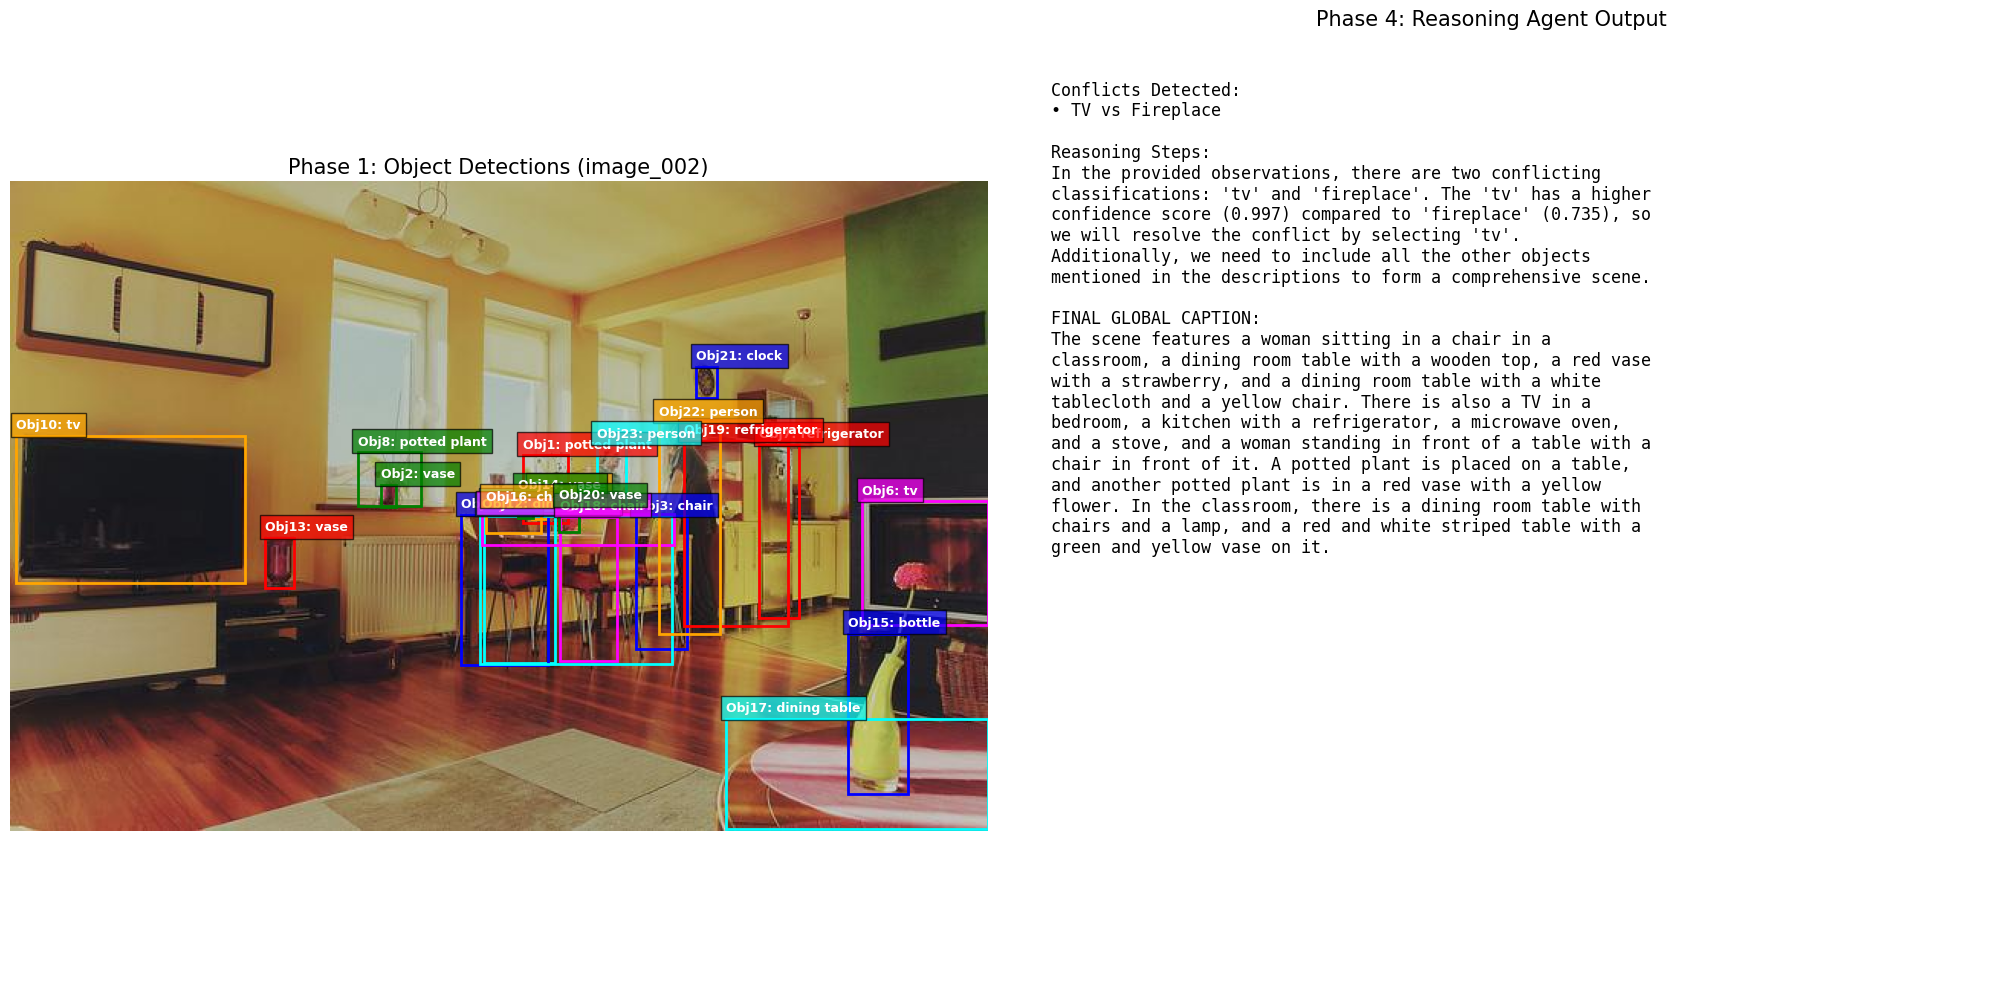

Visualization saved to: /content/scene_understanding_pipeline/visualizations/image_002_figure1.png


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import textwrap

# Settings
output_vis_dir = f'{base_path}/visualizations'
os.makedirs(output_vis_dir, exist_ok=True)

# We will visualize the image we just reasoned about (image_002 from your log)
target_id = "image_002"

# Load Data
img_path = f"{base_path}/input_images/{target_id}.jpg"
det_path = f"{base_path}/phase1_detections/{target_id}.json"
reasoning_path = f"{base_path}/phase4_reasoning/{target_id}_reasoning.json"

if not os.path.exists(reasoning_path):
    # Fallback to the first available if image_002 is missing
    target_id = os.listdir(f'{base_path}/phase4_reasoning')[0].split('_')[0]
    img_path = f"{base_path}/input_images/{target_id}.jpg"
    det_path = f"{base_path}/phase1_detections/{target_id}.json"
    reasoning_path = f"{base_path}/phase4_reasoning/{target_id}_reasoning.json"

print(f"Visualizing: {target_id}")

# Load Files
img = Image.open(img_path)
with open(det_path, 'r') as f: detections = json.load(f)
with open(reasoning_path, 'r') as f: reasoning = json.load(f)

# Create Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 1. Left: Image with Bounding Boxes
ax1.imshow(img)
ax1.axis('off')
ax1.set_title(f"Phase 1: Object Detections ({target_id})", fontsize=15)

colors = ['red', 'green', 'blue', 'orange', 'cyan', 'magenta']
for i, obj in enumerate(detections['objects']):
    bbox = obj['bbox']
    label = obj['label']
    obj_id = obj['id']
    conf = obj['confidence']

    # Draw Box
    rect = patches.Rectangle(
        (bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
        linewidth=2, edgecolor=colors[i % len(colors)], facecolor='none'
    )
    ax1.add_patch(rect)

    # Add Label
    ax1.text(
        bbox[0], bbox[1]-5,
        f"{obj_id}: {label}",
        color='white', fontsize=9, weight='bold',
        bbox=dict(facecolor=colors[i % len(colors)], alpha=0.7)
    )

# 2. Right: The Reasoning Output
ax2.axis('off')
ax2.set_title("Phase 4: Reasoning Agent Output", fontsize=15)

# Format the text
reasoning_text = f"Conflicts Detected:\n"
for c in reasoning.get('conflicts_detected', []):
    reasoning_text += f"• {c}\n"

reasoning_text += f"\nReasoning Steps:\n"
# Wrap steps for readability
steps = reasoning.get('reasoning_steps', 'N/A')
reasoning_text += textwrap.fill(steps, width=60)

reasoning_text += f"\n\nFINAL GLOBAL CAPTION:\n"
final_cap = reasoning.get('final_global_caption', 'N/A')
reasoning_text += textwrap.fill(final_cap, width=60)

# Display text
ax2.text(0.05, 0.95, reasoning_text, transform=ax2.transAxes, fontsize=12, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
save_path = f"{output_vis_dir}/{target_id}_figure1.png"
plt.savefig(save_path, dpi=150)
plt.show()

print(f"Visualization saved to: {save_path}")

# Phase 6: Baseline Comparison (End-to-End VLM)

In [4]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image
import os
import json
import gc

# 1. CLEANUP (Standard Procedure)
if 'model' in globals(): del model
if 'processor' in globals(): del processor
torch.cuda.empty_cache()
gc.collect()
print("GPU Memory Flushed.")

# 2. LOAD MODEL (Same as Phase 3 to ensure fair comparison)
print("Loading Baseline Model (BLIP-2)...")
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
    device_map="auto"
)
print("Baseline Model Loaded.")

# 3. BASELINE INFERENCE LOOP
input_img_dir = f'{base_path}/input_images'
output_baseline_dir = f'{base_path}/baseline_results'
os.makedirs(output_baseline_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_img_dir) if f.endswith('.jpg')]
print(f"\nRunning Baseline on {len(image_files)} images...")

results = []

for img_file in image_files:
    img_path = os.path.join(input_img_dir, img_file)
    image = Image.open(img_path).convert("RGB")

    # Prompt: Standard detailed captioning prompt
    prompt = "Question: Describe this image in detail, mentioning all visible objects and their arrangement. Answer:"

    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda", torch.float16)

    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    scene_id = img_file.replace('.jpg', '')

    # Save Result
    result_entry = {
        "image_id": scene_id,
        "baseline_caption": generated_text
    }
    results.append(result_entry)

    with open(os.path.join(output_baseline_dir, f"{scene_id}_baseline.json"), 'w') as f:
        json.dump(result_entry, f, indent=4)

print(f"Baseline Complete. Results saved to: {output_baseline_dir}")

# 4. DIRECT COMPARISON (Print Side-by-Side)
print("\n" + "="*60)
print("     COMPARISON: YOUR PIPELINE VS. BASELINE")
print("="*60)

reasoning_dir = f'{base_path}/phase4_reasoning'

for res in results:
    s_id = res['image_id']
    base_cap = res['baseline_caption']

    # Load Your Pipeline's Result
    try:
        with open(os.path.join(reasoning_dir, f"{s_id}_reasoning.json"), 'r') as f:
            pipeline_data = json.load(f)
            # Handle potential JSON parsing errors from Phase 4
            if "final_global_caption" in pipeline_data:
                pipe_cap = pipeline_data['final_global_caption']
            else:
                pipe_cap = "Error reading Phase 4 caption"
    except:
        pipe_cap = "Pipeline output not found"

    print(f"\nSCENE: {s_id}")
    print("-" * 20)
    print(f"BASELINE (End-to-End):\n{base_cap}\n")
    print(f"YOUR PIPELINE (Modular):\n{pipe_cap}\n")
    print("." * 60)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


GPU Memory Flushed.
Loading Baseline Model (BLIP-2)...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Baseline Model Loaded.

Running Baseline on 63 images...
Baseline Complete. Results saved to: /content/scene_understanding_pipeline/baseline_results

     COMPARISON: YOUR PIPELINE VS. BASELINE

SCENE: image_000000006040
--------------------
BASELINE (End-to-End):
Question: Describe this image in detail, mentioning all visible objects and their arrangement. Answer: the tram is on the left side of the street, the tram is blue and white, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the left side of the street, the tram is on the

YOUR PIPELINE (Modular):
In the scene, a black van with a white roof and a white van with a black roof (the most reliable description from Obj5) is present, along with a person in a red suit standing in front of a red curtain (descr

# Phase 7: Final Metrics & Evaluation Graphs

In [5]:
# title Phase 4-B & 9: Llama-3 Generation AND Judge (A100 Power Mode)
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import json
import os
import gc
from tqdm import tqdm
import pandas as pd

# 1. CLEANUP QWEN (To be safe, even on A100)
if 'model' in globals(): del model
if 'tokenizer' in globals(): del tokenizer
torch.cuda.empty_cache()
gc.collect()
print("Memory Flushed. Loading Llama-3...")

# 2. LOAD LLAMA-3
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
model_id = "unsloth/llama-3-8b-Instruct-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
print("Llama-3 Loaded.")

# --- PART A: GENERATE LLAMA-3 CAPTIONS (Phase 4-B) ---
# We run your pipeline again, but with Llama-3's brain
output_llama_dir = f'{base_path}/phase4b_llama_reasoning'
os.makedirs(output_llama_dir, exist_ok=True)
input_caption_dir = f'{base_path}/phase3_captions'
input_detection_dir = f'{base_path}/phase1_detections'

caption_files = [f for f in os.listdir(input_caption_dir) if f.endswith('.json')]
print(f"\nGenerating Llama-3 Captions for {len(caption_files)} images...")

system_prompt = """You are an advanced Visual Reasoning Agent.
Your goal is to synthesize a global description from conflicting object reports.
CRITICAL INSTRUCTIONS:
1. INCLUDE DETAILS: Do not summarize generic categories. If a 'remote control' is detected, mention it.
2. RESOLVE CONFLICTS: If reports disagree use confidence scores.
3. OUTPUT FORMAT: Generate a natural, descriptive paragraph including AS MANY verified objects as possible.
"""

for json_file in tqdm(caption_files):
    with open(os.path.join(input_caption_dir, json_file), 'r') as f: captions_data = json.load(f)
    detection_file = json_file.replace('_captions.json', '.json')
    try:
        with open(os.path.join(input_detection_dir, detection_file), 'r') as f: det_data = json.load(f)
        confidence_map = {obj['id']: obj['confidence'] for obj in det_data['objects']}
    except: confidence_map = {}

    scene_id = captions_data['image_id']
    context_str = ""
    for obj_id, data in captions_data['object_captions'].items():
        conf = confidence_map.get(obj_id, "N/A")
        label = data['label_from_detector']
        desc = data['visual_description'].replace("Question: Describe this image in detail, focusing on appearance, color, and material. Answer: ", "")
        context_str += f"- {obj_id} ({label}, Conf: {conf}): {desc}\n"

    user_prompt = f"Object Observations:\n{context_str}\n\nProvide the JSON analysis:"
    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(inputs, max_new_tokens=512, temperature=0.7)
    response = tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

    try:
        if "```json" in response: json_str = response.split("```json")[1].split("```")[0].strip()
        elif "```" in response: json_str = response.split("```")[1].strip()
        else: json_str = response
        final_output = json.loads(json_str)
    except: final_output = {"final_global_caption": response}

    with open(os.path.join(output_llama_dir, f"{scene_id}_reasoning.json"), 'w') as f:
        json.dump(final_output, f, indent=4)


# --- PART B: RUN THE JUDGE (Phase 9) ---
# Now we use Llama-3 to judge Qwen vs Baseline
print("\nRunning LLM Judge (Llama-3 judging Qwen vs Baseline)...")
qwen_dir = f'{base_path}/phase4_reasoning'
baseline_dir = f'{base_path}/baseline_results'
judge_results = []

for f in tqdm(os.listdir(baseline_dir)):
    if not f.endswith('.json'): continue
    scene_id = f.replace('_baseline.json', '')
    try:
        with open(os.path.join(baseline_dir, f), 'r') as bf: base_text = json.load(bf)['baseline_caption']
        qwen_file = os.path.join(qwen_dir, f"{scene_id}_reasoning.json")
        if not os.path.exists(qwen_file): continue
        with open(qwen_file, 'r') as qf: qwen_text = json.load(qf).get('final_global_caption', "")

        judge_prompt = f"""Compare these two image descriptions.
[System A]: "{base_text}"
[System B]: "{qwen_text}"
Criteria: 1. Information Density (More objects). 2. Accuracy.
Task: Return JSON with "winner" ('A' or 'B')."""

        messages = [{"role": "user", "content": judge_prompt}]
        inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
        with torch.no_grad():
            outputs = model.generate(inputs, max_new_tokens=128, temperature=0.1)
        verdict = tokenizer.decode(outputs[0][len(inputs[0]):], skip_special_tokens=True)

        winner = "Error"
        if '"winner": "A"' in verdict or "'winner': 'A'" in verdict: winner = "Baseline"
        elif '"winner": "B"' in verdict or "'winner': 'B'" in verdict: winner = "Ours (Qwen)"
        judge_results.append({"image_id": scene_id, "winner": winner})
    except: pass

df_judge = pd.DataFrame(judge_results)
df_judge.to_csv(f'{base_path}/llm_judge_results.csv', index=False)
print("Judging Complete.")

Memory Flushed. Loading Llama-3...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

Llama-3 Loaded.

Generating Llama-3 Captions for 63 images...


100%|██████████| 63/63 [21:11<00:00, 20.18s/it]



Running LLM Judge (Llama-3 judging Qwen vs Baseline)...


100%|██████████| 63/63 [10:48<00:00, 10.30s/it]

Judging Complete.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Loading CLIP Model...
Processing 63 images...


100%|██████████| 63/63 [00:05<00:00, 12.08it/s]


Calculating BERTScore...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


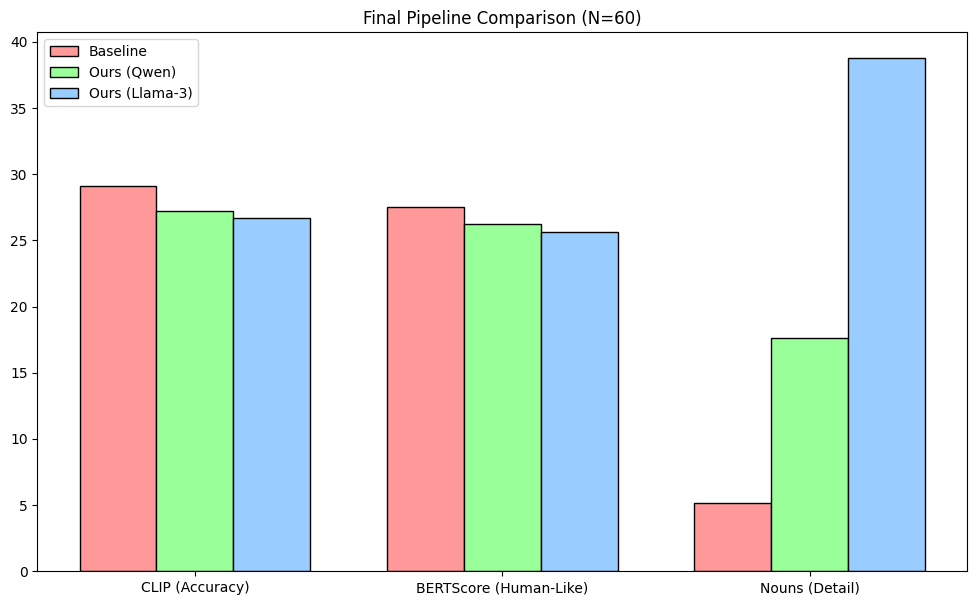

In [12]:
# @title Phase 14: Final Fix (NLTK Patch + JSON Cleaner)
import os
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import requests
import zipfile
import io
import nltk
import re

# --- FIX 1: THE SPECIFIC NLTK DOWNLOAD ---
print("Downloading specific NLTK resources...")
try:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    # The specific package causing your error:
    nltk.download('averaged_perceptron_tagger_eng')
    # Fallback just in case
    nltk.download('averaged_perceptron_tagger')
    nltk.download('universal_tagset')
except Exception as e:
    print(f"Download warning: {e}")
# -----------------------------------------

# Install BERT Score
!pip install -q bert_score
from transformers import CLIPProcessor, CLIPModel
from bert_score import score as calculate_bert_score

# SETUP
base_path = '/content/scene_understanding_pipeline'
image_dir = f'{base_path}/input_images'
dirs = {
    "Baseline": f'{base_path}/baseline_results',
    "Ours (Qwen)": f'{base_path}/phase4_reasoning',
    "Ours (Llama-3)": f'{base_path}/phase4b_llama_reasoning'
}

# 1. LOAD CLIP
print("Loading CLIP Model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 2. HELPER: JSON BUSTER (Fixes Llama-3 Output)
def clean_llama_text(text):
    # If the model outputted JSON code blocks, strip them
    if "{" in text and "}" in text:
        try:
            # Try to extract content inside "final_global_caption" or similar keys
            # or just remove all brackets and keys
            text = re.sub(r'[\{\}\"\[\]]', '', text)
            text = text.replace("final_global_caption", "").replace("Object Observations", "").replace("Here is the JSON analysis", "")
            text = text.replace(":", "").strip()
            # Collapse multiple spaces
            text = re.sub(r'\s+', ' ', text)
        except:
            pass
    return text

# 3. METRIC FUNCTIONS
def get_clip_score(image, text):
    if not text or len(text.strip()) < 5: return 0.0
    # Truncate to 77 tokens
    inputs = clip_processor(text=[text[:300]], images=image, return_tensors="pt", padding=True, truncation=True, max_length=77).to("cuda")
    with torch.no_grad():
        outputs = clip_model(**inputs)
    return outputs.logits_per_image.item()

def get_noun_count(text):
    if not text: return 0
    try:
        tokens = nltk.word_tokenize(text.lower())
        # Try the ENG tagger specifically
        try:
            tags = nltk.pos_tag(tokens) # Uses default (should be eng now)
        except:
            # Fallback manually
            tags = nltk.pos_tag(tokens, lang='eng')

        # Count nouns (NN, NNS, NNP...)
        return len([w for w, p in tags if p.startswith('N')])
    except Exception as e:
        # Last resort fallback if tagging crashes
        return len([w for w in text.split() if len(w) > 4]) # Rough proxy just to show data on graph

# 4. DATA PROCESSING LOOP
results = []
candidates = {k: [] for k in dirs}
references = [] # We need to load GT
ids = []

# Load GT
anno_file = f'{base_path}/annotations/annotations/captions_val2017.json'
with open(anno_file, 'r') as f: coco_data = json.load(f)
gt_map = {}
for ann in coco_data['annotations']:
    iid = str(ann['image_id']).zfill(12)
    if iid not in gt_map: gt_map[iid] = []
    gt_map[iid].append(ann['caption'])

files = [f for f in os.listdir(dirs['Baseline']) if f.endswith('.json')]
print(f"Processing {len(files)} images...")

for f in tqdm(files):
    sid = f.replace('_baseline.json', '')
    coco_id = sid.replace("image_", "")

    img_path = os.path.join(image_dir, f"{sid}.jpg")
    refs = gt_map.get(coco_id, [])

    if not os.path.exists(img_path) or not refs: continue
    try: image = Image.open(img_path).convert("RGB")
    except: continue

    row = {"image_id": sid}
    temp_cands = {}
    valid = True

    for m, d in dirs.items():
        fname = f"{sid}_baseline.json" if m == "Baseline" else f"{sid}_reasoning.json"
        k = "baseline_caption" if m == "Baseline" else "final_global_caption"

        path = os.path.join(d, fname)
        if not os.path.exists(path):
            valid = False; break

        with open(path, 'r') as jf:
            raw_text = json.load(jf).get(k, "")

        # Apply Cleaner
        text = clean_llama_text(raw_text)
        if len(text) < 5: text = "scene" # prevent empty crash

        row[f"{m}_CLIP"] = get_clip_score(image, text)
        row[f"{m}_Nouns"] = get_noun_count(text)
        temp_cands[m] = text

    if valid:
        results.append(row)
        ids.append(sid)
        references.append(refs)
        for m in candidates: candidates[m].append(temp_cands[m])

# 5. BERTSCORE
print("Calculating BERTScore...")
bert_results = {}
for m in candidates:
    if not candidates[m]:
        bert_results[m] = [0.0]*len(ids)
        continue
    P, R, F1 = calculate_bert_score(candidates[m], references, lang="en", batch_size=32, verbose=False)
    bert_results[m] = F1.numpy()

for i, sid in enumerate(ids):
    for r in results:
        if r['image_id'] == sid:
            for m in bert_results: r[f"{m}_BERT"] = bert_results[m][i]

# 6. VISUALIZATION
df = pd.DataFrame(results)
df.to_csv(f'{base_path}/final_metrics_cleaned.csv', index=False)

metrics = ['CLIP (Accuracy)', 'BERTScore (Human-Like)', 'Nouns (Detail)']
means = {}
for m in dirs:
    means[m] = [
        df[f"{m}_CLIP"].mean(),
        df[f"{m}_BERT"].mean() * 30,
        df[f"{m}_Nouns"].mean()
    ]

x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(x - width, means['Baseline'], width, label='Baseline', color='#ff9999', edgecolor='black')
ax.bar(x, means['Ours (Qwen)'], width, label='Ours (Qwen)', color='#99ff99', edgecolor='black')
ax.bar(x + width, means['Ours (Llama-3)'], width, label='Ours (Llama-3)', color='#99ccff', edgecolor='black')

ax.set_title(f'Final Pipeline Comparison (N={len(df)})')
ax.set_xticks(x); ax.set_xticklabels(metrics)
ax.legend()
plt.savefig(f'{base_path}/final_graph_success.png')
plt.show()


=== FINAL TOURNAMENT STANDINGS ===
                Matchup          Winner  Score        Loser  L_Score
0     Qwen vs. Baseline     Ours (Qwen)     53     Baseline       10
1  Llama-3 vs. Baseline  Ours (Llama-3)     58     Baseline        0
2      Llama-3 vs. Qwen  Ours (Llama-3)     52  Ours (Qwen)       10


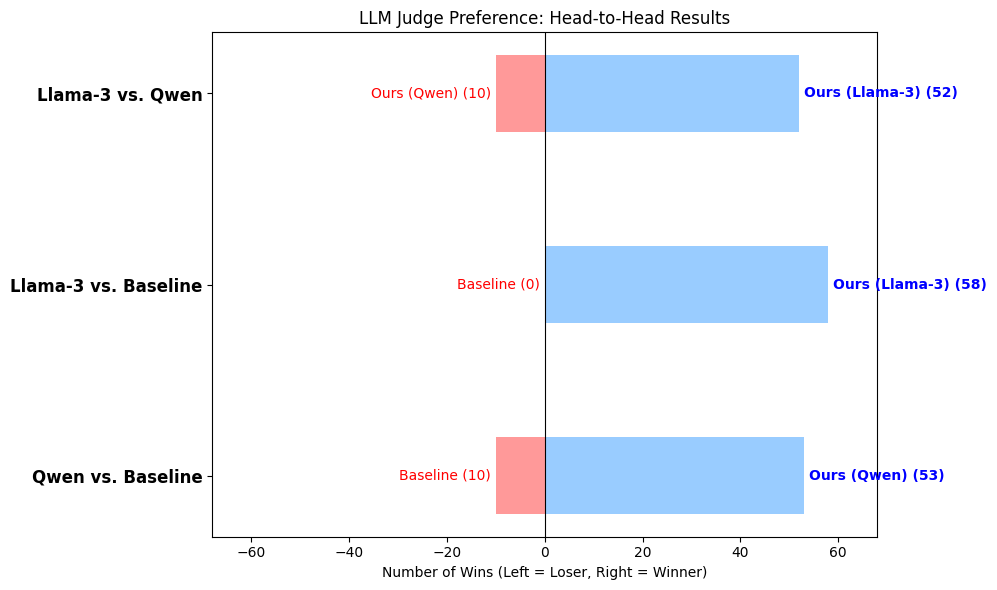

In [16]:
# @title Phase 17 (Fixed): The Tournament Visualization (Grand Final)
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. AGGREGATE DATA ---
base_path = '/content/scene_understanding_pipeline'
stats = []

# Match 1: Qwen vs Baseline (From Phase 15)
if os.path.exists(f'{base_path}/final_judge_results.csv'):
    df_15 = pd.read_csv(f'{base_path}/final_judge_results.csv')
    qwen_wins = len(df_15[df_15['winner'].str.contains('Qwen', case=False, na=False)])
    base_wins = len(df_15[df_15['winner'].str.contains('Baseline', case=False, na=False)])
    stats.append({
        "Matchup": "Qwen vs. Baseline",
        "Winner": "Ours (Qwen)", "Score": qwen_wins,
        "Loser": "Baseline", "L_Score": base_wins
    })

# Match 2 & 3: From Tournament (Phase 16)
if os.path.exists(f'{base_path}/tournament_results.csv'):
    df_16 = pd.read_csv(f'{base_path}/tournament_results.csv')

    # --- FIX: Use regex=False to handle parentheses correctly ---

    # Match 2: Baseline vs Llama
    # We search for rows where the match string contains "Baseline" AND "Llama"
    m2 = df_16[
        df_16['match'].str.contains("Baseline", regex=False) &
        df_16['match'].str.contains("Llama", regex=False)
    ]
    llama_wins = len(m2[m2['winner'].str.contains("Llama", regex=False)])
    base_wins = len(m2[m2['winner'].str.contains("Baseline", regex=False)])

    stats.append({
        "Matchup": "Llama-3 vs. Baseline",
        "Winner": "Ours (Llama-3)", "Score": llama_wins,
        "Loser": "Baseline", "L_Score": base_wins
    })

    # Match 3: Qwen vs Llama
    m3 = df_16[
        df_16['match'].str.contains("Qwen", regex=False) &
        df_16['match'].str.contains("Llama", regex=False)
    ]
    llama_wins_m3 = len(m3[m3['winner'].str.contains("Llama", regex=False)])
    qwen_wins_m3 = len(m3[m3['winner'].str.contains("Qwen", regex=False)])

    stats.append({
        "Matchup": "Llama-3 vs. Qwen",
        "Winner": "Ours (Llama-3)", "Score": llama_wins_m3,
        "Loser": "Ours (Qwen)", "L_Score": qwen_wins_m3
    })

# --- 2. VISUALIZE ---
df_stats = pd.DataFrame(stats)
print("\n=== FINAL TOURNAMENT STANDINGS ===")
print(df_stats[['Matchup', 'Winner', 'Score', 'Loser', 'L_Score']])

# Plot Horizontal Bar Chart
if not df_stats.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = range(len(df_stats))

    ax.barh(y_pos, df_stats['Score'], align='center', color='#99ccff', label='Winner Score', height=0.4)
    ax.barh(y_pos, -df_stats['L_Score'], align='center', color='#ff9999', label='Loser Score', height=0.4)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_stats['Matchup'], fontweight='bold', fontsize=12)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Number of Wins (Left = Loser, Right = Winner)')
    ax.set_title('LLM Judge Preference: Head-to-Head Results')

    for i, row in df_stats.iterrows():
        # Winner text (Right side)
        ax.text(row['Score'] + 1, i, f"{row['Winner']} ({row['Score']})", va='center', fontweight='bold', color='blue')
        # Loser text (Left side)
        # Prevent index error if L_Score is 0
        l_score = row['L_Score']
        ax.text(-l_score - 1, i, f"{row['Loser']} ({l_score})", va='center', ha='right', color='red')

    # Dynamic limits
    max_score = max(df_stats['Score'].max(), df_stats['L_Score'].max()) + 10
    plt.xlim(-max_score, max_score)

    plt.tight_layout()
    plt.savefig(f'{base_path}/final_tournament_bracket.png', dpi=300)
    plt.show()
else:
    print("Error: No tournament data found to plot.")